In [1]:
import os
import sys 
import re
import pickle

import pandas as pd
import time 
import numpy as np

from typing import Iterable
from datetime import datetime
import pytz

from pathlib import Path
from dotenv import load_dotenv
load_dotenv() 

import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
from shapely import make_valid
from geopy.geocoders import Nominatim
from geopy.geocoders import OpenCage
import copy
import folium
from folium.features import GeoJson, GeoJsonTooltip

# Initialize Nominatim API
geolocator = OpenCage(os.getenv("OPEN_CAGE_KEY") )

In [2]:
from shapely import make_valid

# Load GIS Data from Different Datasets

In [3]:

from pathlib import Path
import geopandas as gpd

# Define the base directory paths
data_dir = Path('../data/')
data_input = data_dir / 'input'
data_output = data_dir / 'output'
geo_data = data_dir / "geo_data"

# Dictionary to store file paths and GeoDataFrames
data_dict = {
    # 'artist_df_path': data_output / "artists_locations_gpt-4o.csv",
    'cbsa_gdf': gpd.read_file(geo_data / "tl_2023_us_cbsa"),
    # 'states_gdf': gpd.read_file(geo_data / "tlgdb_2023_a_us_nationgeo.gdb"),
    # 'countries_gdf': gpd.read_file(geo_data / "custom.geo.json"),
    'canada_places': gpd.read_file(geo_data / "canada_statistical_areas"),
    'NYC_Boroughs': gpd.read_file(geo_data / "NYC_Boroughs"),
    'LA_County': gpd.read_file(geo_data / "LA_COUNTY"),
    'UK_admin1': gpd.read_file(geo_data / 'gb.json'),
    'countries2_gdf': gpd.read_file(geo_data / 'world-administrative-boundaries'),
}


#https://www2.census.gov/geo/tiger/TIGER2023/CBSA/
#https://www2.census.gov/geo/tiger/TGRGDB23/
#https://hub.arcgis.com/datasets/esri::world-countries-generalized/explore
#https://www12.statcan.gc.ca/census-recensement/alternative_alternatif.cfm?l=eng&dispext=zip&teng=ler_000b21a_e.zip&k=%20%20%20133463&loc=//www12.statcan.gc.ca/census-recensement/2021/geo/sip-pis/boundary-limites/files-fichiers/ler_000b21a_e.zip
#https://arc-gis-hub-home-arcgishub.hub.arcgis.com/datasets/DCP::nyc-borough-boundary/explore?location=40.775612%2C-74.442021%2C9.36
#https://egis-lacounty.hub.arcgis.com/datasets/8ea349021cf544adb9bb079d3631df77_0/explore?location=33.797441%2C-118.298821%2C7.60
#https://simplemaps.com/gis/country/gb#admin1
#world_aministrative_boundaries


# Normalize Data

In [4]:
for key in data_dict.keys():
    # Ensure all GeoDataFrames have the same CRS (WGS 84 - EPSG:4326)
    data_dict[key] = data_dict[key].to_crs("EPSG:4326")
    # Ensure there are no rows without geometries
    data_dict[key]  = data_dict[key].dropna(subset = 'geometry')
    # Fix any invalid geometreis
    data_dict[key]['geometry'] = data_dict[key]['geometry'].apply(
    lambda geom: make_valid(geom) if not geom.is_valid else geom
)

# Rename columns for consistency
data_dict['countries2_gdf'] = data_dict['countries2_gdf'].rename(columns={'name': 'NAMELSAD'})
data_dict['canada_places'] = data_dict['canada_places'].rename(columns={'CMANAME': 'NAMELSAD'})
data_dict['NYC_Boroughs'] = data_dict['NYC_Boroughs'].rename(columns={'BoroName': 'NAMELSAD'})
data_dict['LA_County'] = data_dict['LA_County'].rename(columns={'CITY_COMM_': 'NAMELSAD'})
data_dict['UK_admin1'] = data_dict['UK_admin1'].rename(columns={'name': 'NAMELSAD'})

In [5]:
#Rename to Kington, Ontario to avoid overlap with Kingston Borough in London
data_dict['canada_places'].loc[data_dict['canada_places']['NAMELSAD'] == 'Kingston', 'NAMELSAD'] = 'Kingston, Ontario'


In [6]:
data_dict['canada_places'][data_dict['canada_places']['NAMELSAD']=='Kingston']['NAMELSAD']


Series([], Name: NAMELSAD, dtype: object)

In [7]:
full_gdf = copy.deepcopy(data_dict['countries2_gdf'])

#DROP US, Puerto Rico, and Great Britain/Northern Ireland from full map
indexes_to_drop = full_gdf[full_gdf['iso_3166_1_'].isin([
    'PR',
    'US',
    'GB'
    ]
    )].index

# Drop these rows by index
full_gdf.drop(indexes_to_drop, inplace=True)

# Cookie cut statistcal areas from CANADA/US
for subset in [data_dict['canada_places'],
              
            #    cbsa_gdf
               ]:
    full_gdf['geometry'] = full_gdf['geometry'].difference(subset.unary_union)

# Cookie cut LA NYC subboudries from US CBSA
for subset in [data_dict['LA_County'],data_dict['NYC_Boroughs']]:
    data_dict['cbsa_gdf']['geometry'] = data_dict['cbsa_gdf']['geometry'].difference(subset.unary_union)


import pandas as pd
import geopandas as gpd

# Define the keys you want to omit
keys_to_omit = {'countries2_gdf'}

# Automatically filter GeoDataFrames, excluding the specified keys
geo_frames = [
    gdf[['NAMELSAD', 'geometry']] for key, gdf in data_dict.items() 
    if key not in keys_to_omit and isinstance(gdf, gpd.GeoDataFrame) and 'NAMELSAD' in gdf.columns
]

# Concatenate all the filtered GeoDataFrames (outer join by default)
full_gdf = pd.concat(geo_frames + [full_gdf], ignore_index=True)

# Ensure the result is a valid GeoDataFrame
full_gdf = gpd.GeoDataFrame(full_gdf, geometry='geometry')


In [8]:

def merge_geometries(gdf, merge_dict):
    """
    Merges regions in the GeoDataFrame based on the provided dictionary.

    Parameters:
    gdf (GeoDataFrame): The original GeoDataFrame.
    merge_dict (dict): A dictionary where keys are new region names, 
                       and values are lists of region names to be merged.

    Returns:
    GeoDataFrame: Updated GeoDataFrame with merged geometries.
    """
    for new_name, regions in merge_dict.items():
        # Filter the GeoDataFrame for the regions to merge
        region_gdf = gdf[gdf['NAMELSAD'].isin(regions)]
        
        # Perform a union of all geometries in these regions
        merged_geometry = region_gdf.unary_union
        
        # Create a new row for the merged region
        merged_row = gpd.GeoDataFrame({'NAMELSAD': [new_name], 'geometry': [merged_geometry]})
        
        # Drop the original rows
        gdf = gdf[~gdf['NAMELSAD'].isin(regions)]
        
        # Concatenate the new merged row with the remaining rows
        gdf = pd.concat([gdf, merged_row], ignore_index=True)
    
    return gdf


# Define the regions to merge with their new names
# https://en.wikipedia.org/wiki/North_London
# https://en.wikipedia.org/wiki/South_London
merge_dict = {
    'Central London': ['Camden', 'Islington', 'Kensington and Chelsea', 'Westminster'],
    'North London': ['Barnet','Enfield','Haringey'],
    'South London': ['Bexley','Bromley','Croydon','Greenwich','Kingston','Lambeth','Lewisham','Merton','Richmond','Southwark','Sutton','Wandsworth'],
    'East London': ['Hackney','Havering','Newham','Redbridge','Waltham Forest','Barking and Dagenham','Tower Hamlets'],
    'West London': ['Brent','Ealing','Hammersmith','Harrow','Hillingdon','Hounslow']

}

# # Apply the merging function to the GeoDataFrame
full_gdf = merge_geometries(full_gdf, merge_dict)

/Users/Xavaar/anaconda3/envs/musicMetricGis_312/lib/python3.12/site-packages/geopandas/array.py:1459: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))
/Users/Xavaar/anaconda3/envs/musicMetricGis_312/lib/python3.12/site-packages/geopandas/array.py:1459: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))
/Users/Xavaar/anaconda3/envs/musicMetricGis_312/lib/python3.12/site-packages/geopandas/array.py:1459: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))
/Users/Xavaar/anaconda3/envs/musicMetricGis_312/lib/python3.12/site-packages/geopandas/array.py:1459: UserWarning: CRS no

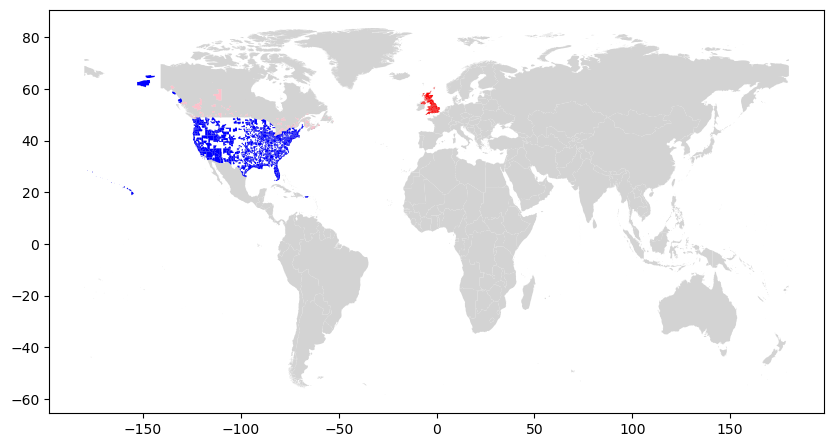

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
full_gdf.plot(ax=ax, color='lightgrey')
data_dict['cbsa_gdf'].plot(ax=ax, color='blue')
data_dict['canada_places'].plot(ax=ax, color='pink')
data_dict['UK_admin1'].plot(ax=ax, color='red')
data_dict['NYC_Boroughs'].plot(ax=ax, color='purple')

plt.show()


In [10]:
# Export to shapefile
full_gdf.to_file(geo_data / 'master_map' /'master_map.shp')

/var/folders/qw/fj_kmtln1pgdf2ygth937jqc0000gn/T/ipykernel_55902/1616916780.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  full_gdf.to_file(geo_data / 'master_map' /'master_map.shp')
